In [2]:
%pip install kagglehub

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import kagglehub

In [ ]:
# Download latest path
path = kagglehub.dataset_download("waqi786/remote-work-and-mental-health")

csv_file_path = f"{path}/Impact_of_Remote_Work_on_Mental_Health.csv"

# Load the dataset
df = pd.read_csv(csv_file_path)

df.head()

,Employee_ID,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Region
0,EMP0001,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,Medium,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good,Europe
1,EMP0002,40,Female,Data Scientist,IT,3,Remote,52,4,1,Medium,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good,Asia
2,EMP0003,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,Medium,Anxiety,No,No Change,4,Unsatisfied,5,NaN,Poor,North America
3,EMP0004,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,High,Depression,Yes,Increase,3,Unsatisfied,3,NaN,Poor,Europe
4,EMP0005,49,Male,Sales,Consulting,32,Onsite,35,12,2,High,NaN,Yes,Decrease,3,Unsatisfied,3,Weekly,Average,North America


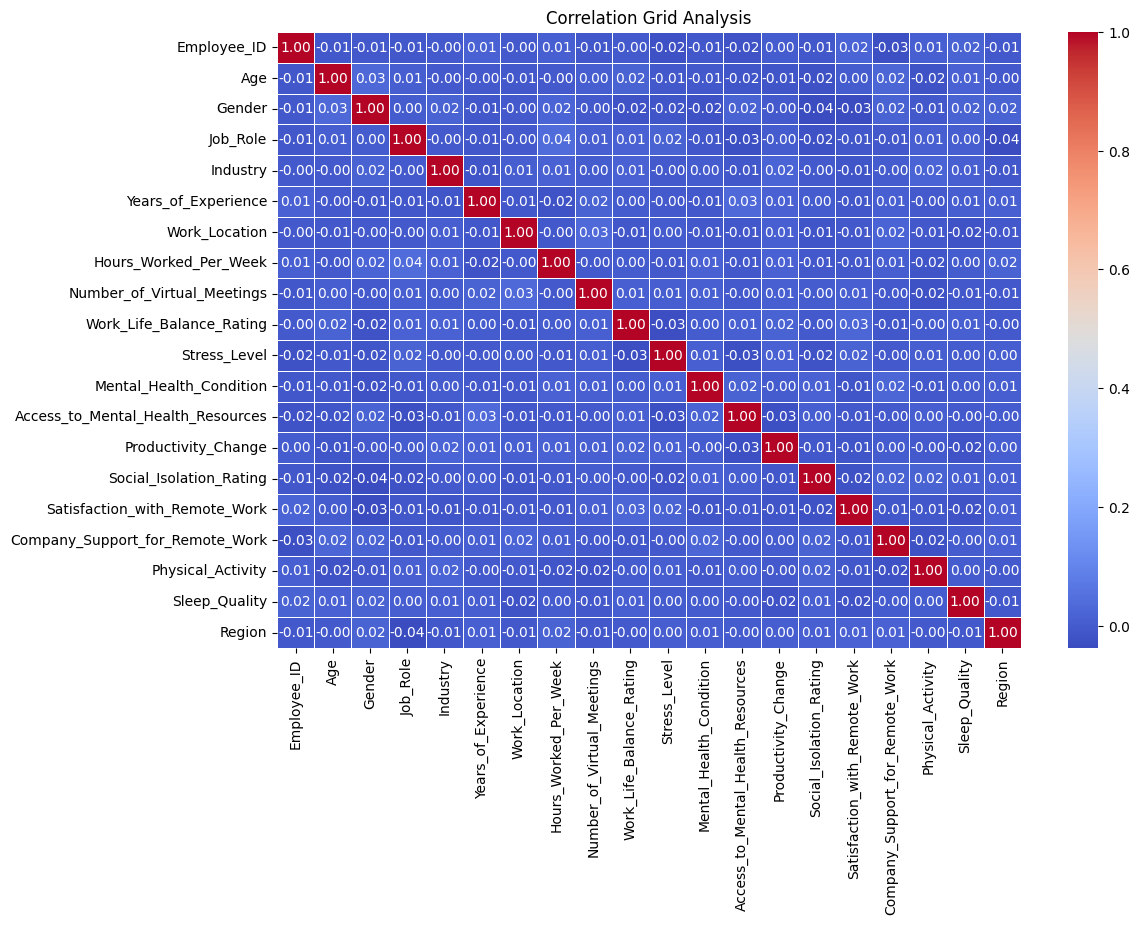

In [35]:
# Convert non-numeric data to numeric for correlation calculation
df_numeric = df.copy()
for col in df_numeric.select_dtypes(include='object').columns:
    df_numeric[col] = df_numeric[col].astype('category').cat.codes

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Plot the correlation grid as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Grid Analysis")
plt.show()

**Preprocessing the Data**

We focus on extracting relevant features, handling missing data, and encoding categorical variables into numerical values. These transformations ensure the data is compatible with machine learning models.

In [24]:
columns_to_keep = [
    "Age", "Gender", "Job_Role", "Industry", 
    "Years_of_Experience", "Hours_Worked_Per_Week", 
    "Stress_Level", "Work_Location"
]
df_filtered = df[columns_to_keep]
df_filtered_stress = df_filtered[df_filtered["Stress_Level"].isin(["Low"])]
df_cleaned = df_filtered_stress.dropna()
df_final = df_cleaned.drop(columns=["Stress_Level"])

df_final.head()

,Age,Gender,Job_Role,Industry,Years_of_Experience,Hours_Worked_Per_Week,Work_Location
6,31,Prefer not to say,Sales,IT,24,51,Remote
9,30,Female,HR,IT,28,57,Hybrid
13,51,Non-binary,Designer,Manufacturing,5,45,Hybrid
15,56,Female,Sales,Healthcare,13,44,Remote
17,45,Non-binary,Data Scientist,Consulting,20,37,Onsite


In [25]:
len(df_final)

1645

In [26]:
X = df_final.drop(columns=["Work_Location"])
y = df_final["Work_Location"]  

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


In [27]:
# Grid search with cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring="f1_macro", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and corresponding model
best_dt = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the model on the test set
y_pred = best_dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\Aiden\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy: 0.3353584447144593
Precision: 0.3387188572836932
F1 Score: 0.3331272573327401

Classification Report:
               precision    recall  f1-score   support

      Hybrid       0.36      0.25      0.30       287
      Onsite       0.34      0.35      0.34       265
      Remote       0.32      0.41      0.36       271

    accuracy                           0.34       823
   macro avg       0.34      0.34      0.33       823
weighted avg       0.34      0.34      0.33       823



In [32]:
best_dt.fit(X_train, y_train)  # Fit the best model from GridSearchCV
feature_importances = pd.Series(best_dt.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

Years_of_Experience           0.351697
Age                           0.162677
Hours_Worked_Per_Week         0.151909
Gender_Prefer not to say      0.044845
Job_Role_Software Engineer    0.041487
Industry_Education            0.040828
Job_Role_HR                   0.033228
Job_Role_Sales                0.032196
Industry_Healthcare           0.030329
Industry_Finance              0.024144
Gender_Male                   0.020020
Industry_IT                   0.016243
Gender_Non-binary             0.013956
Job_Role_Designer             0.012464
Industry_Retail               0.008767
Industry_Manufacturing        0.008533
Job_Role_Project Manager      0.006678
Job_Role_Marketing            0.000000
dtype: float64


In [33]:
X_train

,Age,Years_of_Experience,Hours_Worked_Per_Week,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Job_Role_Designer,Job_Role_HR,Job_Role_Marketing,Job_Role_Project Manager,Job_Role_Sales,Job_Role_Software Engineer,Industry_Education,Industry_Finance,Industry_Healthcare,Industry_IT,Industry_Manufacturing,Industry_Retail
2862,44,34,56,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3727,41,13,43,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False
4116,27,22,51,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
1652,30,22,21,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False
4976,52,33,39,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3490,57,23,22,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False
4009,23,28,45,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False
2637,44,19,33,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
4506,49,15,50,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest F1 Score:", f1_score(y_test, y_pred, average="macro"))

Random Forest Accuracy: 0.3402187120291616
Random Forest F1 Score: 0.3391075046311341


We use one-hot encoding for categorical features like gender, job role, and industry. The target variable (Work_Location) is mapped to numerical values for classification.
- 0 - Onsite
- 1 - Hybrid
- 2 - Remote

Similarly, we also map the Productivity_Change values to numerical values for classification.

**Creating Company Samples**

Since the goal is to predict the optimal work model for companies, we create samples of 10 employees to represent individual companies. This helps simulate real-world scenarios where decisions are made at the company level.

In [24]:
# Create random samples of 10 employees per company
def create_company_samples(df, sample_size=10):
    companies = []
    while len(df) >= sample_size:
        sample = df.sample(sample_size)
        df = df.drop(sample.index)
        companies.append(sample)
    return companies

companies = create_company_samples(data, sample_size=10)

Here, we generate multiple company samples, each consisting of 10 employees from the dataset.

**Aggregating Data for Each Company**

We compute aggregate statistics (e.g., mean values) for numerical features within each company. The target variable is determined by the majority work model label among the 10 employees.

In [25]:
# Aggregate data for each company
company_features = []
company_labels = []

for company in companies:
    # Aggregate numeric features only
    numeric_features = company.drop(columns=["Work_Location"]).select_dtypes(include=['number']).mean().to_dict()

    # Determine the majority work location
    majority_label = company["Work_Location"].mode()[0]

    company_features.append(numeric_features)
    company_labels.append(majority_label)

# Convert features and labels to DataFrame and NumPy array
X = pd.DataFrame(company_features)
y = np.array(company_labels)

This step reduces the dimensionality of the data and ensures each company is represented by a single record.

**Splitting Data and Training the Model**

We split the aggregated data into training and testing sets, train a Random Forest classifier, and evaluate its performance.

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Model Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Model Performance:
              precision    recall  f1-score   support

           0       0.37      0.39      0.38        28
           1       0.31      0.38      0.34        21
           2       0.45      0.33      0.38        27

    accuracy                           0.37        76
   macro avg       0.37      0.37      0.37        76
weighted avg       0.38      0.37      0.37        76

Accuracy: 0.3684210526315789


Random Forest is chosen for its ability to handle both classification tasks and complex interactions between features. The evaluation metrics include accuracy and a detailed classification report.

**Predicting the Optimal Work Model**

Finally, we create a function to predict the best work model for a new company based on varying the Work_Location parameter. This function simulates the scenario of testing different work models for a given workforce.

In [29]:
# Get the list of features used for training
feature_columns = X_train.columns

# Function to predict optimal work model for a new company
def recommend_work_model(new_company_data, model):
    locations = ["Onsite", "Hybrid", "Remote"]
    results = {}
    for location in locations:
        temp_data = new_company_data.copy()
        temp_data["Work_Location"] = location_mapping[location]

        # Aggregate features and ensure alignment with training data
        temp_features = pd.DataFrame([temp_data.mean()], columns=feature_columns).fillna(0)

        # Predict work model
        result = model.predict(temp_features)[0]
        results[location] = result
    return max(results, key=results.get)

# Simulating a new company input
new_company = companies[0].drop(columns="Work_Location")  # Use one of the existing samples
optimal_model = recommend_work_model(new_company, model)
print(f"Recommended Work Model for the new company: {optimal_model}")

Recommended Work Model for the new company: Onsite


Accuracy: 0.37
Classification Report:
              precision    recall  f1-score   support

      Onsite       0.37      0.39      0.38        28
      Hybrid       0.31      0.38      0.34        21
      Remote       0.45      0.33      0.38        27

    accuracy                           0.37        76
   macro avg       0.37      0.37      0.37        76
weighted avg       0.38      0.37      0.37        76

Confusion Matrix:
[[11 10  7]
 [ 9  8  4]
 [10  8  9]]


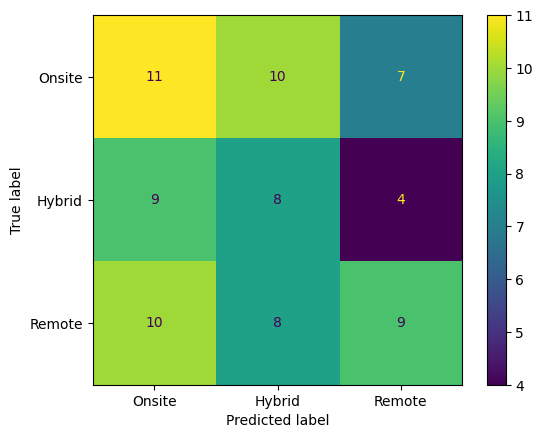

In [32]:
# Evaluate the model with additional metrics
y_pred = model.predict(X_test)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=["Onsite", "Hybrid", "Remote"])
print("Classification Report:")
print(report)

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
print(cm)

# Plot confusion matrix (if running in an environment that supports plots)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Onsite", "Hybrid", "Remote"])
disp.plot(cmap="viridis")